- Find the missing observations in the dataset

In [1]:
import os
import sys
import math
import torch
import gpytorch
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

# Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plot_helpers import *
plotter = PlotUtilGPyTorch()

Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("./data/sim_noisy_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

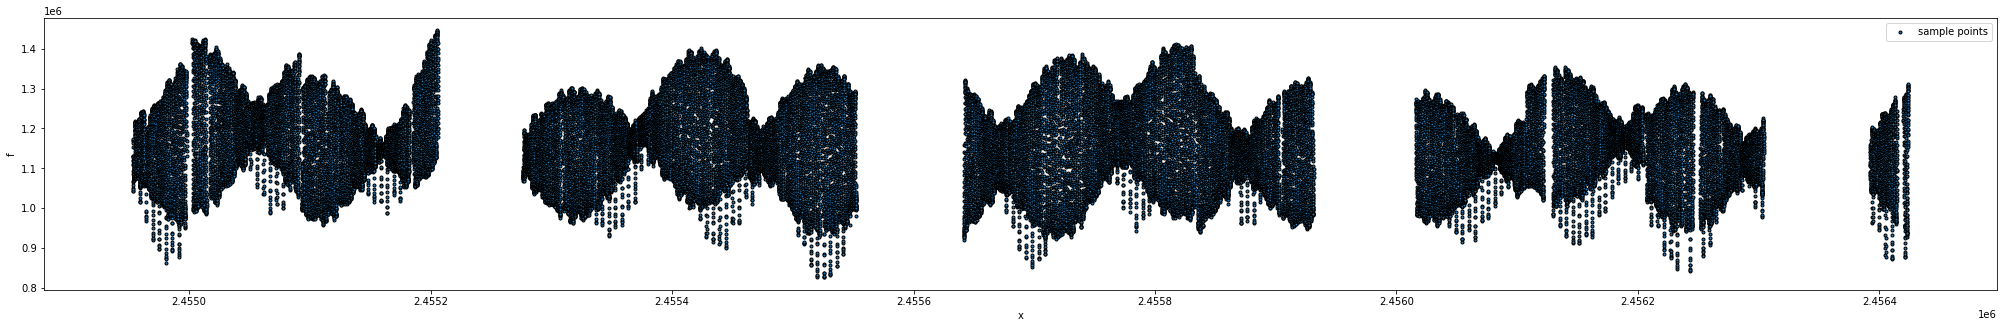

In [5]:
plotter.plot_data(X, Y)

# 2. Processing


Compose a Gaussian Process from a reasonable guess of kernels

In [6]:
X[1] - X[0], X[2] - X[1], X[3] - X[2]


(0.020434249192476273, 0.0204341490752995, 0.020434349309653044)

In [8]:
X_periods = np.diff(X, n=1)

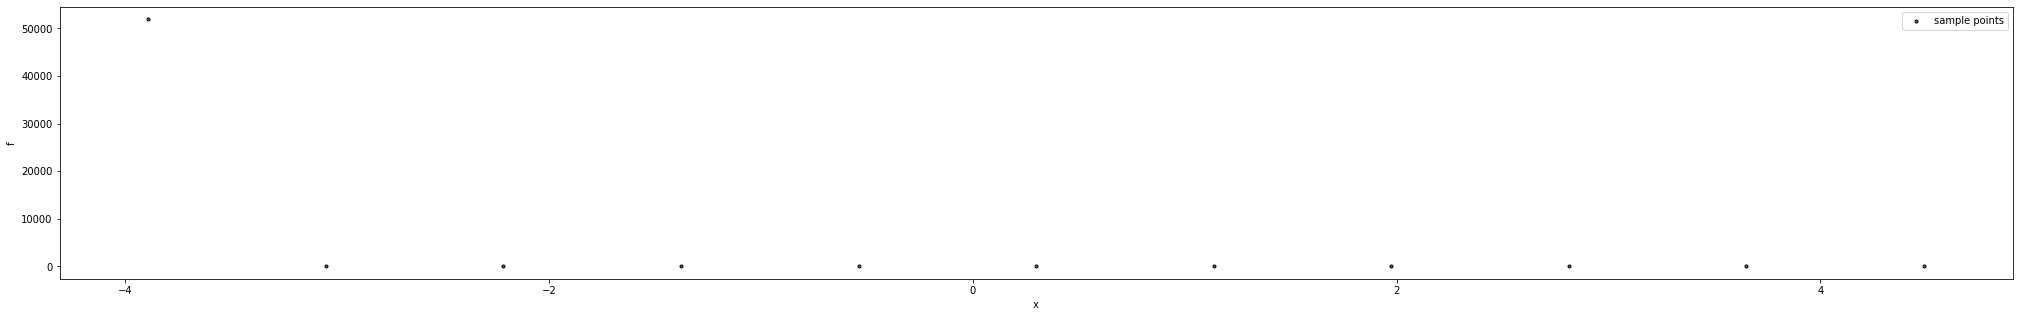

In [33]:
hist, bin_edges = np.histogram(np.log(X_periods), bins=10)
plotter.plot_data(bin_edges, np.append(hist, [0]))

In [34]:
median_sampling_period = np.median(X_periods)
median_sampling_period

0.020433524157851934

In [73]:
X_periods[X_periods>1000*median_sampling_period]/median_sampling_period

array([3440.0470601 , 4355.02005243, 4132.02912866, 4312.03478943])

In [76]:
(4000*29.5)/60/24

81.94444444444444

In [56]:
# Predict evenly spaced points on our time-axis using the median sampling period
X_periods = np.diff(X, n=1)
median_sampling_period = np.median(X_periods)
X_expected = np.arange(X.min(), X.max(), median_sampling_period)

In [57]:
len(X_expected)

71964

In [64]:
# Let's try to plot the histogram of the sampling period, excluding the large gaps.
X_small_periods = X_periods[X_periods<2*median_sampling_period]

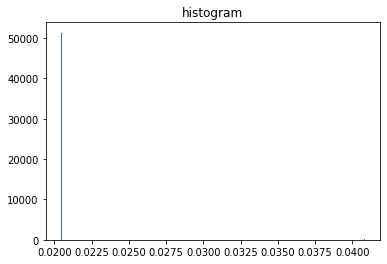

In [70]:
plt.hist(X_small_periods, bins = 300) 
plt.title("histogram") 
plt.show()

In [72]:
X_small_periods[:100]

array([0.02043425, 0.02043415, 0.02043435, 0.02043425, 0.02043415,
       0.02043425, 0.02043435, 0.02043415, 0.02043425, 0.02043435,
       0.02043415, 0.02043425, 0.02043425, 0.02043425, 0.02043425,
       0.02043425, 0.02043435, 0.02043415, 0.02043425, 0.02043435,
       0.02043415, 0.02043425, 0.02043415, 0.02043435, 0.02043425,
       0.02043425, 0.02043425, 0.02043425, 0.02043425, 0.02043415,
       0.02043435, 0.02043425, 0.02043415, 0.02043435, 0.02043425,
       0.02043415, 0.02043425, 0.02043435, 0.02043425, 0.02043415,
       0.02043435, 0.02043425, 0.02043415, 0.02043425, 0.02043435,
       0.02043415, 0.02043425, 0.02043425, 0.02043435, 0.02043425,
       0.02043415, 0.02043435, 0.02043425, 0.02043415, 0.02043425,
       0.02043435, 0.02043415, 0.02043425, 0.02043435, 0.02043415,
       0.02043425, 0.02043425, 0.02043425, 0.02043425, 0.02043425,
       0.02043425, 0.02043425, 0.02043425, 0.02043415, 0.02043435,
       0.02043425, 0.02043415, 0.02043435, 0.02043425, 0.02043